In [1]:
# Import Libraries
import torch
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# Mounting Google Drive to access files stored in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Function to print evaluation metrics
def evaluate_model(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

In [4]:
# Prepare Dataset
class SentimentDataset(Dataset):
  def __init__(self, texts, labels):
    self.texts = texts.reset_index(drop=True)
    self.labels = labels.reset_index(drop=True)

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    encodings = tokenizer(self.texts[idx], truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    return encodings['input_ids'].squeeze(), encodings['attention_mask'].squeeze(), torch.tensor(self.labels[idx])

# Create Evaluation Function
def evaluate(model, data_loader):
  model.eval()  # Set the model to evaluation mode
  all_labels = []
  all_predictions = []
  with torch.no_grad():  # Disable gradient computation
    for batch in data_loader:
      input_ids, attention_mask, labels = batch
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      labels = labels.to(device)
      # Forward pass
      outputs = model(input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      predictions = torch.argmax(logits, dim=1)
      # Append labels and predictions for metric calculation
      all_labels.extend(labels.cpu().numpy())
      all_predictions.extend(predictions.cpu().numpy())

    # Calculate accuracy, precision, recall, and F1-scores
    evaluate_model(all_labels, all_predictions)
    # Confusion matrix for DistilBERT
    textblob_cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
    sns.heatmap(textblob_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
    plt.title("Fine-Tuned DistilBERT Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    return

# Create Training Function
def train(model, optimizer, data_loader, lr_scheduler):
  model.train()
  for batch in data_loader:
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    # Backward pass
    loss.backward()
    # Optimizer step and scheduler update
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
  print(f"Training Loss: {loss.item()}")

In [5]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/NLP_Project/IMDB_Dataset_Preprocessed.csv')
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [6]:
# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)

print("Training set size:", train_df.shape)
print("Testing set size:", test_df.shape)

train_dataset = SentimentDataset(train_df['cleaned_review'], train_df['sentiment'])
test_dataset = SentimentDataset(test_df['cleaned_review'], test_df['sentiment'])

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

Training set size: (25000, 20)
Testing set size: (25000, 20)


In [7]:
# Load Pretrained Model and Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
# Set Up Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 5
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
# Move model to GPU Available
device = torch.device("cuda")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Training Loss: 0.15999193489551544
Accuracy: 0.89
Precision: 0.85
Recall: 0.95
F1-Score: 0.90


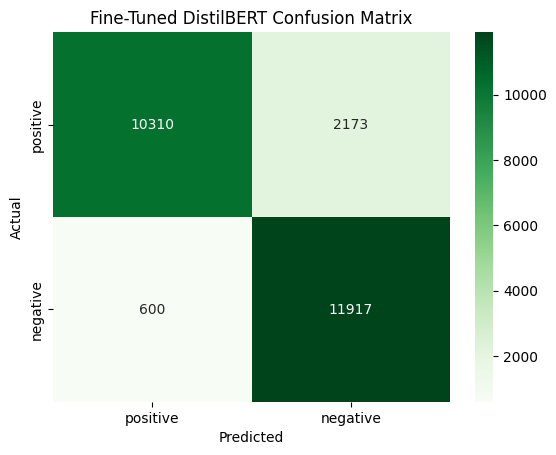

Training Loss: 0.2879743278026581
Accuracy: 0.90
Precision: 0.94
Recall: 0.85
F1-Score: 0.89


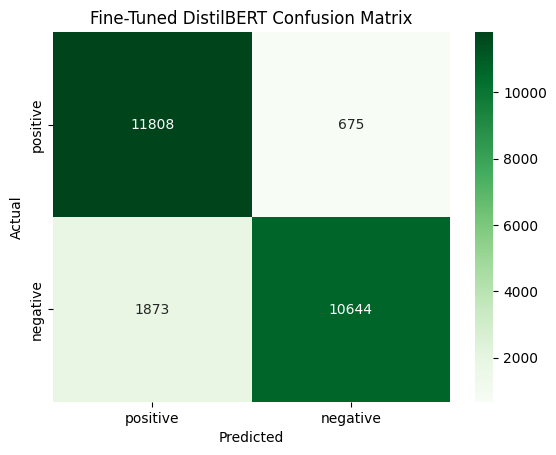

Training Loss: 0.01336096040904522
Accuracy: 0.90
Precision: 0.88
Recall: 0.93
F1-Score: 0.90


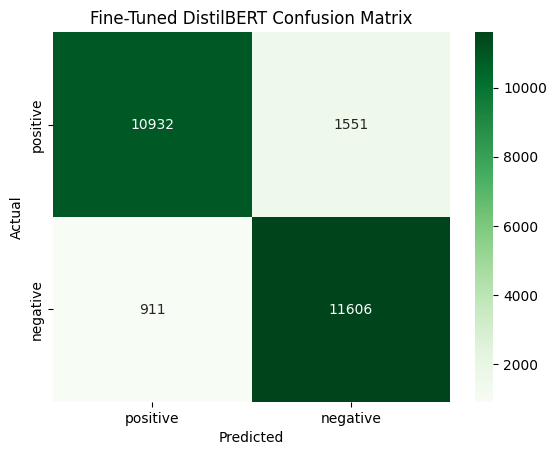

Training Loss: 0.006809042301028967
Accuracy: 0.90
Precision: 0.90
Recall: 0.91
F1-Score: 0.90


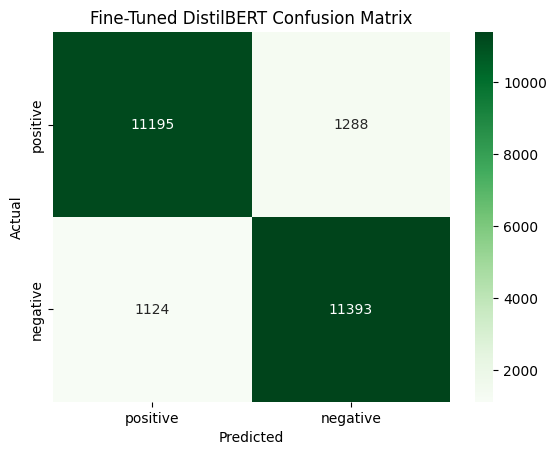

Training Loss: 0.1085706353187561
Accuracy: 0.90
Precision: 0.91
Recall: 0.90
F1-Score: 0.90


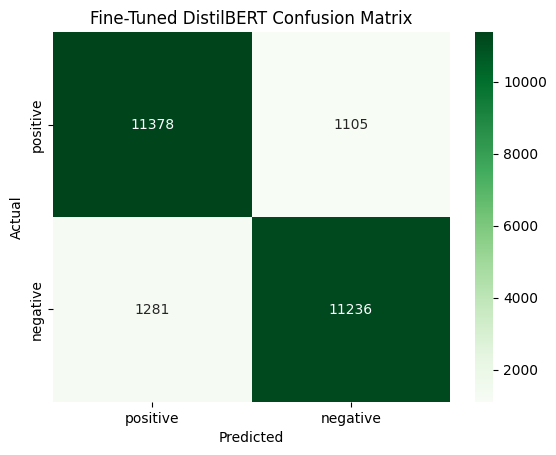

In [8]:
# Train and Test Model
for epoch in range(num_epochs):
  train(model, optimizer, train_loader, lr_scheduler)
  evaluate(model, test_loader)
  # Save the Fine-Tuned Model
  model.save_pretrained("/content/drive/MyDrive/NLP_Project/fine_tuned_distilbert")
  tokenizer.save_pretrained("/content/drive/MyDrive/NLP_Project/fine_tuned_distilbert")